### Installation de certains requirements

In [8]:
!pip3 install tqdm einops
# !pip3 install torch
# !pip3 install torchvision
!pip3 install torchmetrics

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


### Importation des librairies

In [1]:
# Librairies utilisées
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from utilitaires import psnr_from_model, load_data, train_model, function_for_comparison, plot_result
from Models_Architectures import VisionTransformer

## Model parameters specification
Please pay attention to every single line of the following cell code

In [29]:
CT = False               # Training with CT data or not
patch_size = 8          # Patch size (P) = 16 = 64/4
latent_size = 64       # Latent vector (D) (an hyperparameter)
num_heads = 8           # ViT-Base uses 8 heads because embed dimension must be divisible by num_heads,

num_encoders = 12       # ViT-Base uses 12 encoder layers
dropout = 0.1           # Dropout = 0.1 is used with ViT-Base & ImageNet-21k
size = 224              # Size used for training = 224
final_dim = 64*64       # 

epochs = 10             # Number of epochs
base_lr = 8e-4          # Base LR
weight_decay = 0.0      # Weight decay for ViT-Base (on ImageNet-21k)
batch_size = 40         # Penser à rendre le 64 normal
loss_fn = nn.L1Loss()
save_path = './Saved_models/model_vit_final_10_epochs_64_latent_8_patch_ct.pth'


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_channels = 2 if CT else 1  # Number of channels for input images
print("Device :", device)
print("Channel number :", n_channels)

Device : cpu
Channel number : 1


## Importation et préparation des données 

In [4]:
# Download data
type_data = ["low_edep", "high_edep", "ct"]
low_samp_data = load_data("MCsimulations", type_data[0])
high_samp_data = load_data("MCsimulations", type_data[1])
if CT:
    ct_data = load_data("MCsimulations", type_data[2])

# Transform data into tensors
low_samp_tensors = [torch.from_numpy(x).to(torch.float32) for x in low_samp_data]
high_samp_tensors = [torch.from_numpy(x).to(torch.float32) for x in high_samp_data]
if CT:
    ct_tensors = [torch.from_numpy(x).to(torch.float32) for x in ct_data]

In [3]:
import numpy as np
import torch

a = np.array([1, 2, 3])
t = torch.from_numpy(a)
t

tensor([1, 2, 3])

In [5]:
import random

# List of patient indices from 1 to 82
index_patients = list(range(0, 82))

# Set the random seed for reproducibility
random.seed(1)

# Shuffle the list of patient indices
random.shuffle(index_patients)

# Assign indices to training, validation, and test sets
train_index = index_patients[:58]
val_index = index_patients[58:58+16]
test_index = index_patients[58+16:]

# Initialize lists to store training, validation, and test data
Low_train = []
High_train = []
CT_train = []

Low_val = []
High_val = []
CT_val = []

Low_test = []
High_test = []
CT_test = []

# Populate training data
for i in train_index:
    Low_train.extend(low_samp_tensors[i*80: (i+1)*80])
    High_train.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT:
        CT_train.extend(ct_tensors[i*80: (i+1)*80])

# Populate validation data
for i in val_index:
    Low_val.extend(low_samp_tensors[i*80: (i+1)*80])
    High_val.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT:
        CT_val.extend(ct_tensors[i*80: (i+1)*80])

# Populate test data
for i in test_index:
    Low_test.extend(low_samp_tensors[i*80: (i+1)*80])
    High_test.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT:
        CT_test.extend(ct_tensors[i*80: (i+1)*80])

print(f"The train data size is : {len(Low_train)}")
print(f"The validation data size is : {len(Low_val)}")
print(f"The test data size is : {len(Low_test)}")

The train data size is : 4640
The validation data size is : 1280
The test data size is : 640


In [30]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, low, high, ct=None):
        self.low = low
        self.high = high
        self.ct = ct

    def __len__(self):
        return len(self.low)

    def __getitem__(self, idx):
        X = self.low[idx]
        y = self.high[idx]
        
        if self.ct is not None:
            X = torch.stack([self.low[idx], self.ct[idx]], dim=0)
        
        return X, y
    
# DataLoader
if CT:
    dataloader_train = DataLoader(dataset=CustomDataset(Low_train, High_train, CT_train), 
                                batch_size=batch_size, shuffle=True)
    dataloader_val = DataLoader(dataset=CustomDataset(Low_val, High_val, CT_val), 
                                batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset=CustomDataset(Low_test, High_test, CT_test),
                                batch_size=batch_size, shuffle=True)
else :
    dataloader_train = DataLoader(dataset=CustomDataset(Low_train, High_train), 
                                batch_size=batch_size, shuffle=True)
    dataloader_val = DataLoader(dataset=CustomDataset(Low_val, High_val), 
                                batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset=CustomDataset(Low_test, High_test),
                                batch_size=batch_size, shuffle=True)

## Entrainement ViT 

In [31]:
vit_model = VisionTransformer.VitTransformer(num_encoders=num_encoders, 
                                             latent_size=latent_size, 
                                             device=device, 
                                             final_dim=final_dim, 
                                             dropout=dropout, 
                                             patch_size=patch_size,
                                             n_channels=n_channels, 
                                             batch_size=batch_size, 
                                             num_heads=num_heads)

optimizer = torch.optim.Adam(vit_model.parameters(), lr=base_lr)#, weight_decay=weight_decay)
print(vit_model)

VitTransformer(
  (EmbedPatchStack): EmbedPatch(
    (linearProjection): Linear(in_features=64, out_features=64, bias=True)
  )
  (EncoderStack): ModuleList(
    (0-11): 12 x EncoderBlock(
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (enc_MLP): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=256, out_features=64, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (conv_before_upsample): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (upsample): Upsample(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PixelShuffle(upscale

In [33]:
import time

temps = time.time()

vit_model, loss_train_list, loss_val_list = train_model(
    model=vit_model,
    criterion=loss_fn,
    optimizer=optimizer,
    dataloaders={'train': dataloader_train, 'val': dataloader_val},
    device=device,
    n_epochs=epochs,
    save_path=save_path)

print(f'Temps mi : {time.time()-temps}')

torch.save(vit_model.state_dict(), save_path)

Epoch 1
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 1.510591
Validation set:   Avg loss: 0.417349

Epoch 2
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 1.361571
Validation set:   Avg loss: 0.375896

Epoch 3
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 1.311508
Validation set:   Avg loss: 0.361759

Epoch 4
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 1.289268
Validation set:   Avg loss: 0.356259

Epoch 5
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 1.254485
Validation set:   Avg loss: 0.346126

Epoch 6
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 1.226907
Validation set:   Avg loss: 0.338868

Epoch 7
--------------------

## Analyse des résultats

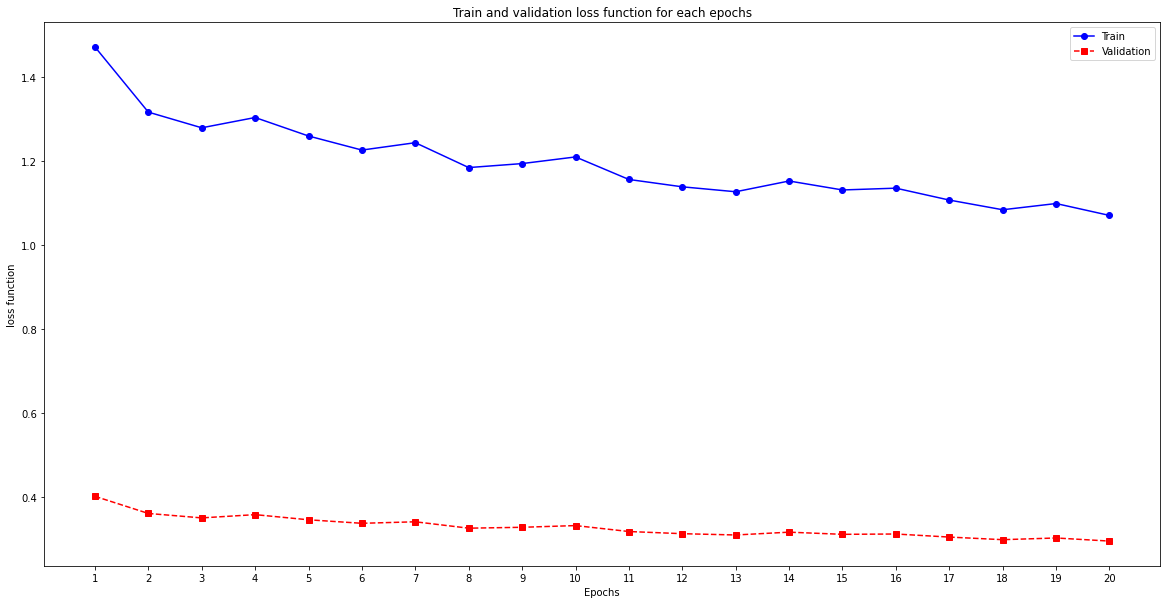

In [72]:
#### Courbes de Loss

loss_train_vect = [1.472182, 1.316954, 1.279614, 1.304102, 1.260091, 1.226586, 1.244156, 1.184922, 1.194420, 1.210242, 1.156610, 1.139102, 1.127358,
                   1.152951, 1.131623, 1.135898, 1.107565, 1.084501, 1.099303, 1.070991]

loss_val_vect = [0.402294, 0.361507, 0.350923, 0.358668, 0.346403, 0.338053, 0.341651, 0.326433, 0.328559, 0.332626, 0.318483, 0.313318, 0.310258,
                 0.316953, 0.311797, 0.312569, 0.305268, 0.299066, 0.303110, 0.295705]

plot_result(x=loss_train_vect, y=loss_val_vect, labelY="loss function")

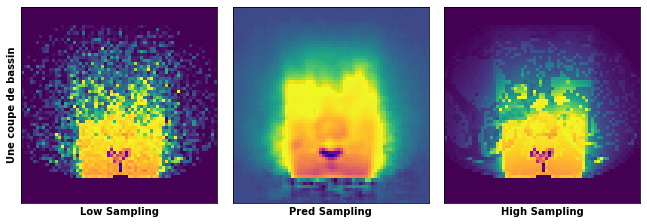

In [76]:
function_for_comparison(model_path=save_path, dataloader=dataloader_test, model=vit_model, CT=CT, ind=30)

In [34]:
# Calcul du PSRN
psnr_from_model(model_path=save_path, 
     dataloader=dataloader_test, 
     model=vit_model,
     ind = 2)

/home/id2167/env/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(


tensor(28.7842)

# Model VIT avec 40 époques,  latent size 64 et 8 patch size, MSE

In [24]:
save_path

'./Saved_models/model_vit_final_10_epochs_64_latent_8_patch_ct.pth'

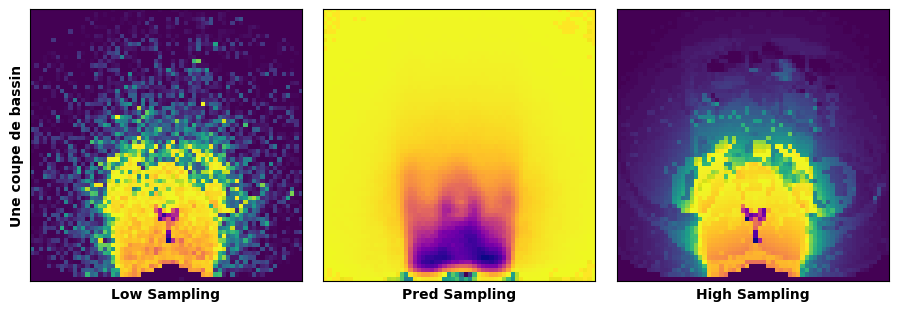

In [39]:
# Chargement du modèle et représentation graphique des résultats
function_for_comparison(model_path=save_path, 
                        dataloader = dataloader_test, 
                        ind = 20, 
                        model = vit_model)

# Model VIT avec 200 époques, 64 latent size  et 8 patch size, MSE

In [29]:
# Parameters spécification
CT = False               # Training with CT data or not
patch_size = 8          # Patch size (P) = 16 = 64/4
latent_size = 32       # Latent vector (D) (an hyperparameter)
num_heads = 8           # ViT-Base uses 8 heads because embed dimension must be divisible by num_heads,

num_encoders = 12       # ViT-Base uses 12 encoder layers
dropout = 0.1           # Dropout = 0.1 is used with ViT-Base & ImageNet-21k
size = 224              # Size used for training = 224
final_dim = 64*64       # 

epochs = 200             # Number of epochs
base_lr = 8e-4          # Base LR
weight_decay = 0.0      # Weight decay for ViT-Base (on ImageNet-21k)
batch_size = 40         # Penser à rendre le 64 normal
loss_fn = nn.L1Loss()
save_path = './Saved_models/model_vit_final_200_epochs_32_latent_8_patch.pth'


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_channels = 2 if CT else 1  # Number of channels for input images
print("Device :", device)
print("Channel number :", n_channels)

Device : cpu
Channel number : 1


In [31]:
# Model definition
vit_model = VisionTransformer.VitTransformer(num_encoders=num_encoders, 
                                             latent_size=latent_size, 
                                             device=device, 
                                             final_dim=final_dim, 
                                             dropout=dropout, 
                                             patch_size=patch_size,
                                             n_channels=n_channels, 
                                             batch_size=batch_size, 
                                             num_heads=num_heads)

optimizer = torch.optim.Adam(vit_model.parameters(), lr=base_lr)
print(vit_model)

VitTransformer(
  (EmbedPatchStack): EmbedPatch(
    (linearProjection): Linear(in_features=64, out_features=32, bias=True)
  )
  (EncoderStack): ModuleList(
    (0-11): 12 x EncoderBlock(
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (multihead): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
      )
      (enc_MLP): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=128, out_features=32, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (conv_before_upsample): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (upsample): Upsample(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PixelShuffle(upscale

In [32]:
# Model training
vit_model, loss_train, loss_val = train_model(
                    model=vit_model,
                    criterion=loss_fn,
                    optimizer=optimizer,
                    dataloaders={'train': dataloader_train, 'val': dataloader_val},
                    device=device,
                    n_epochs=epochs,
                    save_path=save_path)

torch.save(vit_model.state_dict(), save_path)

Epoch 1
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 1.525556
Validation set:   Avg loss: 0.423476

Epoch 2
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 1.326873
Validation set:   Avg loss: 0.372432

Epoch 3
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 1.287052
Validation set:   Avg loss: 0.358972

Epoch 4
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 1.257431
Validation set:   Avg loss: 0.350572

Epoch 5
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 1.251795
Validation set:   Avg loss: 0.348364

Epoch 6
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 1.218069
Validation set:   Avg loss: 0.340847

Epoch 7
--------------------

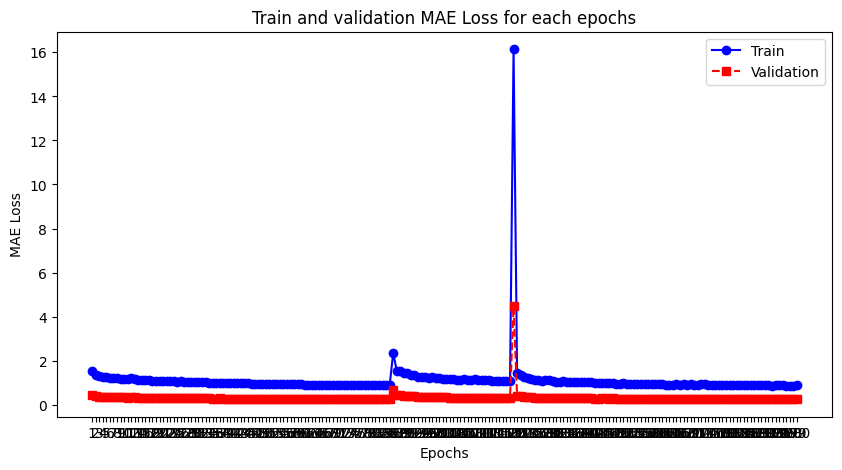

In [33]:
# Evolution of the training
plot_result(loss_train, loss_val, "MAE Loss")

In [57]:
with open("loss_train_Horeb.txt", "w") as opfile:
    opfile.write("\n".join(loss_train))

TypeError: sequence item 0: expected str instance, float found

In [59]:
loss_val


[0.4234764389693737,
 0.3724316246807575,
 0.3589724535122514,
 0.35057195741683245,
 0.3483644723892212,
 0.34084746707230806,
 0.3392939316108823,
 0.3412373121827841,
 0.32775805704295635,
 0.3279195725917816,
 0.3251325683668256,
 0.3425774807110429,
 0.3273732354864478,
 0.3127449946478009,
 0.3106919573619962,
 0.30953739769756794,
 0.307350336574018,
 0.3052269369363785,
 0.3058341173455119,
 0.30341477412730455,
 0.30011560767889023,
 0.29915874637663364,
 0.2985633499920368,
 0.2982640387490392,
 0.29373184964060783,
 0.29645932000130415,
 0.2939148545265198,
 0.2916413927450776,
 0.28642238955944777,
 0.2872728556394577,
 0.28423030488193035,
 0.2860056385397911,
 0.28433285281062126,
 0.28170570358633995,
 0.2790132602676749,
 0.2789183557033539,
 0.27991689275950193,
 0.27796339243650436,
 0.2763837380334735,
 0.2752139326184988,
 0.27524453308433294,
 0.2744130967184901,
 0.27378820069134235,
 0.27331202756613493,
 0.2737649022601545,
 0.270166858099401,
 0.269987347535789

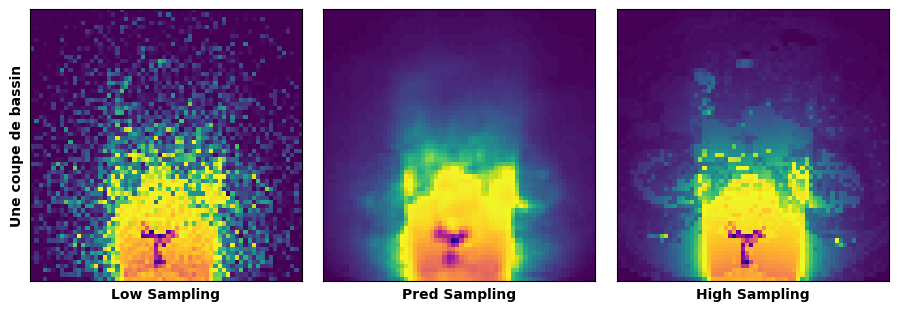

In [55]:
# Visualisation of results 
function_for_comparison(model_path=save_path, dataloader=dataloader_test, 
                        model = VisionTransformer.VitTransformer(latent_size=32, n_channels=1), 
                        ind = 25)

44